<a href="https://colab.research.google.com/github/PrithaSarkar/Dissertation/blob/main/Pull_request_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and importingnecessary packages.

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno

Mounting drive and loading the datafile. Change the location as applicable.

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation UofG 2022/new_pullreq.csv")

In [3]:
columns = df.columns.to_list()
print(columns)

['id', 'project_id', 'github_id', 'pull_request_id', 'ownername', 'reponame', 'merged_or_not', 'lifetime_minutes', 'mergetime_minutes', 'num_commits', 'src_churn', 'test_churn', 'files_added', 'files_deleted', 'files_modified', 'files_changed', 'src_files', 'doc_files', 'other_files', 'num_commit_comments', 'num_issue_comments', 'num_comments', 'num_participants', 'sloc', 'team_size', 'perc_external_contribs', 'commits_on_files_touched', 'test_lines_per_kloc', 'test_cases_per_kloc', 'asserts_per_kloc', 'watchers', 'prev_pullreqs', 'requester_succ_rate', 'followers', 'churn_addition', 'churn_deletion', 'pr_comment_num', 'comment_num', 'perc_neg_emotion', 'perc_pos_emotion', 'perc_neu_emotion', 'part_num_issue', 'part_num_commit', 'part_num_pr', 'part_num_code', 'comment_conflict', 'hash_tag', 'at_tag', 'test_inclusion', 'description_length', 'bug_fix', 'ci_exists', 'ci_latency', 'ci_build_num', 'ci_test_passed', 'ci_failed_perc', 'ci_first_build_status', 'ci_last_build_status', 'languag

The "merged_or_not" metric states whether a pull-request was accepted or not. Let us check, how many of the 3 million pull-request was accepted and how many were rejected.

In [4]:
accepted = 0
rejected = 0
for ind in df.index:
  if df["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(df))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(df))*100)

Accepted: 2710096
Percentage: 80.94823767591804
Rejected: 637841
Percentage: 19.051762324081963


There is a huge imbalance in the two classes. This needs to be kept in mind from this point onwards.

**Preparing data for small-scale experiment.**

The original dataset has 120 columns/metrics related to each pull-request. However, we will only focus on the metrics present in Table 1 of [this paper](https://dl.acm.org/doi/10.1145/3379597.3387489).

In [5]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = int(len(df)/3)):
  for start_row in range(0, dataframe.shape[0], chunk_size):
    end_row  = min(start_row + chunk_size, dataframe.shape[0])
    yield dataframe.iloc[start_row:end_row, :]

In [6]:
get_chunk = flow_from_df(df)
train_eval_test = next(get_chunk)
train_eval_test

,id,project_id,github_id,pull_request_id,ownername,reponame,merged_or_not,lifetime_minutes,mergetime_minutes,num_commits,...,other_comment,num_comments_con,num_code_comments,num_code_comments_con,integrator_availability,friday_effect,contrib_rate_author,reopen_or_not,first_close_minutes,reopen_num
0,1,13708387,1895,16946031,stylelint,stylelint,1,237,237.0,1,...,0,0,0,0,30.0,1,0.007948,0,237,0
1,2,100297899,353,51228565,Joaogarciadelima,checklistos,0,1410,NaN,1,...,0,2,0,0,597.0,0,0.830769,0,1410,0
2,3,93139005,404,42975776,binary-com,SmartCharts,1,4,4.0,1,...,0,0,0,0,2.0,0,0.314368,0,4,0
3,4,15059440,3434,34700062,letsencrypt,boulder,1,52,52.0,1,...,0,0,0,0,1.0,0,0.117332,0,52,0
4,5,29684214,486,34175163,PyCQA,astroid,1,2414,2414.0,1,...,0,0,0,0,2.0,0,0.010753,0,2414,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115974,1115975,5854,747,622191,mozilla,kitsune,0,28,NaN,1,...,0,1,0,0,170.0,0,0.016863,0,28,0
1115975,1115976,22043279,484,10320793,algolia,instantsearch.js,1,170,170.0,4,...,0,2,0,0,26.0,1,0.068429,0,170,0
1115976,1115977,26373298,3749,55041673,palantir,atlasdb,1,224,224.0,7,...,0,0,8,0,5068.0,1,0.000000,0,224,0
1115977,1115978,4952344,16732,61943628,spring-projects,spring-boot,0,2852,NaN,1,...,0,0,0,0,25.0,0,0.022494,0,2852,0


In [7]:
list_of_metrics = ['acc_commit_num', 'first_pr', 'core_member',
                  'contrib_gender', 'same_country', 'same_affiliation',
                  'social_strength', 'account_creation_days',
                  'first_response_time', 'contrib_country',
                  'prior_interaction', 'contrib_affiliation', 'perc_external_contribs',
                  'contrib_first_emo', 'contrib_follow_integrator',
                  'language', 'project_age', 'pushed_delta',
                  'pr_succ_rate', 'open_issue_num', 'open_pr_num', 'fork_num',
                  'churn_addition', 'bug_fix', 'test_inclusion',
                  'hash_tag', 'at_tag', 'part_num_issue', 'part_num_commit',
                  'part_num_pr', 'part_num_code','ci_exists', 'ci_latency',
                  'ci_test_passed', 'ci_failed_perc', 'churn_deletion',
                  'description_length', 'comment_conflict', 'pr_comment_num',
                  'part_num_code', 'ci_build_num', 'perc_inte_neg_emo', 'perc_inte_pos_emo',
                  'perc_inte_neu_emo','ci_first_build_status', 'ci_last_build_status',
                   'merged_or_not']

for metric in columns:
  if metric not in list_of_metrics:
    train_eval_test.drop(metric, axis=1, inplace=True)

train_eval_test

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
0,1,0.089869,0,0,0,1,0,0,0,0,...,NaN,NaN,0.0,0.000000,1.000000,0,28,0.000000,NaN,NaN
1,0,0.014019,0,0,0,1,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,300,0.250000,NaN,NaN
2,1,0.256849,0,0,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,505,0.428571,1.0,NaN
3,1,0.014706,110,3,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,1,460,0.138889,NaN,NaN
4,1,0.173077,60,0,0,1,0,0,0,0,...,NaN,NaN,0.0,1.000000,0.000000,1,6,0.125000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115974,0,0.059289,1,1,0,2,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,0,143,0.352941,NaN,NaN
1115975,1,0.009098,679,6,0,2,0,0,0,0,...,NaN,neutral,0.0,0.333333,0.666667,1,219,0.888889,NaN,NaN
1115976,1,0.042204,373,74,8,0,0,2,2,0,...,NaN,NaN,0.0,0.000000,1.000000,0,0,0.000000,NaN,NaN
1115977,0,0.157848,23,21,0,0,0,0,0,0,...,NaN,NaN,0.0,0.000000,0.000000,1,33,0.070175,NaN,NaN


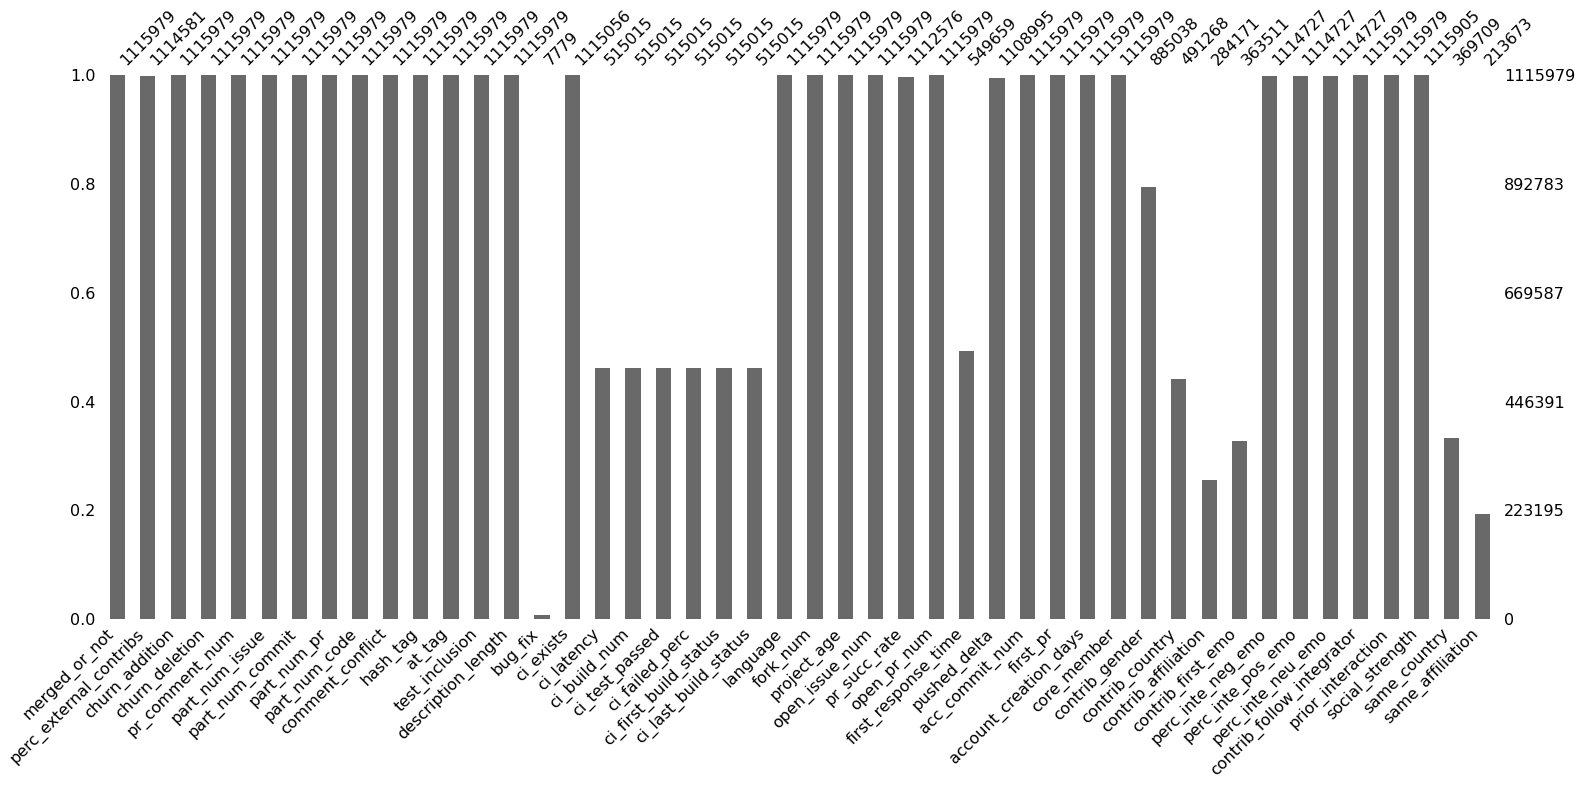

In [8]:
msno.bar(train_eval_test)

Even though there are a couple of metrics which have high number of null values, decision to keep them for now has been taken. Feature selection will be done when XGBoost will be deployed on the data. Subsequently, the most important features will be observed and the rest of them will be dropped from the experiment.

Let us now see the percentage of accepted and rejected pull-request in this data chunk and see if the class imbalance remains the same or has worsened.

In [9]:
accepted = 0
rejected = 0
for ind in train_eval_test.index:
  if train_eval_test["merged_or_not"][ind]==1:
    accepted = accepted+1
  else:
    rejected = rejected+1

print("Accepted:", accepted)
print("Percentage:", (accepted/len(train_eval_test))*100)
print("Rejected:", rejected)
print("Percentage:", (rejected/len(train_eval_test))*100)

Accepted: 903069
Percentage: 80.92168401018299
Rejected: 212910
Percentage: 19.078315989817014


Splitting the train_eval_test dataframe into separate training, evaluation and testing sets. 50% of the entire dataset will be used for training, 30% of the dataset will be used for evaluation/validation purposes and the remaining 20% will be used to run tests.

An important step before that would be to check the data types of every column since classification models would expect int, bool or float daat types. However, the dataset is diverse and annotation is required.

In [10]:
print(train_eval_test.dtypes)

merged_or_not                  int64
perc_external_contribs       float64
churn_addition                 int64
churn_deletion                 int64
pr_comment_num                 int64
part_num_issue                 int64
part_num_commit                int64
part_num_pr                    int64
part_num_code                  int64
comment_conflict               int64
hash_tag                       int64
at_tag                         int64
test_inclusion                 int64
description_length             int64
bug_fix                      float64
ci_exists                    float64
ci_latency                   float64
ci_build_num                 float64
ci_test_passed               float64
ci_failed_perc               float64
ci_first_build_status         object
ci_last_build_status          object
language                      object
fork_num                       int64
project_age                    int64
open_issue_num                 int64
pr_succ_rate                 float64
o

Metrics "ci_first_build_status", "ci_last_build_status", "language", "contrib_gender", contrib_country", "contrib_affiliation", "contrib_first_emo" have data type of object. This would cause trouble when deploying XGBoost. Annotation is needed in this case; manual or otherwise. Let's check the unique values present in each of these metrics.

In [11]:
object_metrics = ['ci_first_build_status', 'ci_last_build_status', 'language', 
                  'contrib_gender', 'contrib_country', 'contrib_affiliation', 'contrib_first_emo']

for metric in object_metrics:
  if metric == 'ci_first_build_status':
    ci_first_build_unique = train_eval_test[metric].unique()
    print(metric,':', ci_first_build_unique, ', #',len(ci_first_build_unique))
  if metric == 'ci_last_build_status':
    ci_last_build_unique = train_eval_test[metric].unique()
    print(metric,':', ci_last_build_unique, ', #',len(ci_last_build_unique))
  if metric == 'language':
    language_unique = train_eval_test[metric].unique()
    print(metric,':', language_unique, ', #',len(language_unique))
  if metric == 'contrib_gender':
    cotrib_gender_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_gender_unique, ', #',len(cotrib_gender_unique))
  if metric == 'contrib_country':
    cotrib_country_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_country_unique, ', #',len(cotrib_country_unique))
  if metric == 'contrib_affiliation':
    cotrib_affiliation_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_affiliation_unique, ', #',len(cotrib_affiliation_unique))
  if metric == 'contrib_first_emo':
    cotrib_first_emo_unique = train_eval_test[metric].unique()
    print(metric,':', cotrib_first_emo_unique, ', #',len(cotrib_first_emo_unique))   

ci_first_build_status : ['success' 'failure' nan] , # 3
ci_last_build_status : ['success' 'failure' nan] , # 3
language : ['JavaScript' 'Python' 'Go' 'Scala' 'Java' 'Ruby'] , # 6
contrib_gender : [nan 'male' 'female'] , # 3
contrib_country : [nan 'malaysia' 'canada' 'united states' 'peru' 'portugal' 'brazil'
 'austria' 'united kingdom' 'hungary' 'south africa' 'nepal' 'nicaragua'
 'russia' 'turkey' 'italy' 'china' 'iran' 'spain' 'czech republic'
 'germany' 'japan' 'nigeria' 'new zealand' 'pakistan' 'philippines'
 'australia' 'sri lanka' 'ukraine' 'switzerland' 'singapore' 'france'
 'belgium' 'chile' 'india' 'poland' 'taiwan' 'bangladesh' 'finland'
 'costa rica' 'netherlands' 'lithuania' 'greece' 'ireland' 'south korea'
 'norway' 'denmark' 'argentina' 'venezuela' 'belarus'
 'northern mariana islands' 'vietnam' 'luxembourg' 'lebanon' 'uzbekistan'
 'sweden' 'bulgaria' 'uganda' 'slovenia' 'croatia' 'united arab emirates'
 'estonia' 'israel' 'panama' 'indonesia' 'latvia' 'mexico' 'romania'


In [12]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for metric in object_metrics:
  train_eval_test[metric] = le.fit_transform(train_eval_test[metric])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [13]:
train = train_eval_test.sample(frac = 0.5)
train_eval_test.drop(train.index)
eval = train_eval_test.sample(frac = 0.3)
train_eval_test.drop(eval.index)
test = train_eval_test.sample(frac = 0.2)

In [14]:
len(train), len(eval), len(test)

(557990, 334794, 223196)

In [15]:
print(train.equals(eval))
print(eval.equals(test))
print(test.equals(train))

False
False
False


In [16]:
train.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
931464,1,0.072804,5,0,0,1,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,120,0.461538,NaN,NaN
681570,1,0.105263,0,0,2,0,0,2,2,0,...,1145,2,0.0,0.0,0.0,0,69,0.050000,1.0,1.0
615058,1,0.000000,1,0,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,90,0.666667,NaN,NaN


In [17]:
eval.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
207330,1,0.056818,33,2,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,112,0.200000,NaN,NaN
752486,1,0.014164,1,1,0,0,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,47,0.176471,NaN,NaN
767323,1,0.027523,0,0,2,0,0,2,2,0,...,1185,0,0.0,1.0,0.0,1,23,0.300000,NaN,NaN


In [18]:
test.head(3)

,merged_or_not,perc_external_contribs,churn_addition,churn_deletion,pr_comment_num,part_num_issue,part_num_commit,part_num_pr,part_num_code,comment_conflict,...,contrib_affiliation,contrib_first_emo,perc_inte_neg_emo,perc_inte_pos_emo,perc_inte_neu_emo,contrib_follow_integrator,prior_interaction,social_strength,same_country,same_affiliation
288073,0,0.040998,17,0,0,2,0,0,0,0,...,1185,3,0.0,0.0,0.0,0,34,0.024691,NaN,NaN
465081,0,0.091667,10,7,0,1,0,0,0,0,...,675,3,0.0,0.0,0.0,0,36,0.022964,NaN,1.0
587931,0,0.103448,103,46,3,0,0,2,2,0,...,1185,1,0.0,0.0,1.0,0,57,0.500000,NaN,NaN


# ***XGBoost***

Run the following cell to install XGBoost. Skip otherwise.

In [19]:
!pip3 install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [24]:
X = train.iloc[:, 1:]
y = train["merged_or_not"]

In [26]:
model = XGBClassifier()

In [27]:
model.fit(X,y)
#cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)

XGBClassifier()

In [ ]:
#print(scores)

[0.81436025 0.81313935 0.80902193 0.81236346 0.80899318 0.81450551
 0.81404711 0.81410546 0.80626014 0.80893936 0.81022745 0.81689755
 0.81175083 0.81408413 0.81201264 0.80959806 0.80990416 0.80933548
 0.81062687 0.81097844 0.8114537  0.80825427 0.81396421 0.81118064
 0.81560937 0.81291348 0.80582168 0.81312888 0.81444109 0.80967596]


In [28]:
print(model.feature_importances_)

[0.00681538 0.01488782 0.00936978 0.0086299  0.04362754 0.00703033
 0.00550964 0.00623537 0.         0.0089388  0.00341481 0.
 0.01772019 0.         0.03861886 0.024624   0.01279854 0.
 0.05124997 0.         0.04231857 0.00990829 0.02394642 0.01430702
 0.02957265 0.01993773 0.03123522 0.03990668 0.01573735 0.06143762
 0.00865192 0.02888217 0.12995444 0.01570054 0.01104786 0.00217
 0.11397329 0.         0.01493471 0.00638754 0.00729071 0.05789842
 0.03980156 0.01184757 0.00368081]


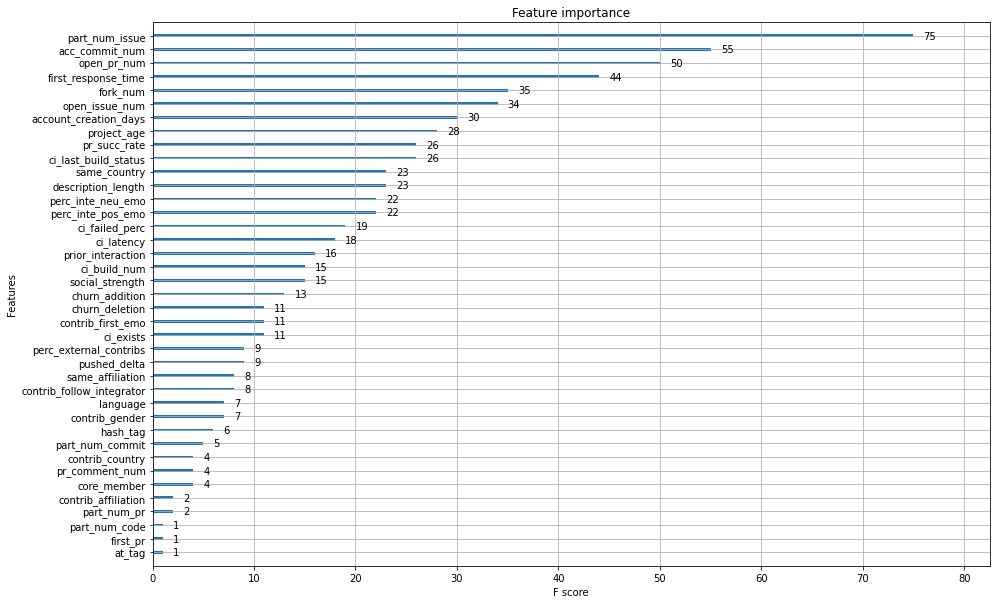

In [63]:
plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(model)
plt.show()

1. Check [this](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/) out.
2. Check [this](https://www.kaggle.com/general/237792) out.